In [85]:
import seaborn as sns
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join

In [86]:
def load_eval(path):
    types = {'robot_state': str}
    df = pd.read_json(path, dtype=types)
    lowest_time = df['time_secs'][0] + 1e-9 * df['time_nsecs'][0]
    relative_times = df['time_secs'] + 1e-9 * df['time_nsecs'] - lowest_time
    df['relative_time'] = relative_times
    return df

In [87]:
# regex captures important properties of filenames.
fileRe = re.compile(r"([^_]+)_(\w+)(\d+).[json|js]")

def CollectData(dirPath):
    start = True
    output = None
    times = {'Human Count': [], 'Final Time': [], 'Policy': []}
    # Load All the filenames in the target directory
    onlyFiles = [f for f in listdir(dirPath) if isfile(join(dirPath, f))]
    for file in onlyFiles:
        match = fileRe.match(file)
        if (not match):
            continue
        humans = 1
        # Get Elements from groups
        iteration = int(match.group(3))
        trial = match.group(2)
        if (trial == 'fast_same_'):
            iteration += 4
        if (trial == 'slow_same_'):
            iteration += 8
        label = match.group(1)
        if (label == 'ga'):
            label = 'Baseline'
        if (label == 'nice'):
            label = 'Nice'
        if (label == 'greedy'):
            label = 'Greedy'
        if (label == 'ref'):
            label = 'Ref'
        if (label == 'niceD'):
            label = 'Nice-D'
        if (label == 'greedyD'):
            label = 'Greedy-D'
        # Load the File
        df = load_eval(dirPath + file)
        # Create extra columns
        hColumn = [humans] * len(df.index)
        labelColumn = [label] * len(df.index)
        finalTime = df['relative_time'].iloc[-1]
        iterColumn = [iteration] * len(df.index)
        if (finalTime >= 90.0):
            finalTime = 90.0
        timeColumn = [finalTime] * len(df.index)
        times['Human Count'].append(humans)
        times['Final Time'].append(finalTime)
        times['Policy'].append(label)
        df['Human Count'] = hColumn
        df['Policy'] = labelColumn
        df['Total Time'] = timeColumn
        df['Trial'] = iterColumn
        if (start):
            output = df
            start = False
        else:
            output = pd.concat([output, df], axis=0)

    return output, pd.DataFrame.from_dict(times)

def CountSuccess(dataDict, timeout):
    output = None
    for key, value in dataDict.items():
        score = 0
        for entry in value:
            time = entry['relative_time'].iloc[-1]
            if (time < timeout):
                score += 1
        output[key] = score
    return output

def CalculateSpeed(df):
    vels_times = df[['robot_vel_x', 'robot_vel_y', 'relative_time']].fillna(0)
    robot_vel_x = vels_times['robot_vel_x']
    robot_vel_y = vels_times['robot_vel_y']
    robot_speed = (robot_vel_x**2 + robot_vel_y**2)**0.5
    return robot_speed

def CalculateForce(df):
    robot_state = df['robot_state']
    df = df[['human_positions', 'robot_pos_x', 'robot_pos_y', 'relative_time']].fillna(0)
    df['robot_state'] = robot_state.fillna('None')
    force_magnitudes = list()
    for index, row in df.iterrows():
        robot_pos_x = row['robot_pos_x']
        robot_pos_y = row['robot_pos_y']
        robot_pos = np.array([robot_pos_x, robot_pos_y])
        human_positions = row['human_positions']
        state = row['robot_state']
        if (human_positions != 0 and len(human_positions) >  0):
            
            human_positions = np.array([np.array([p[0], p[1]]) for p in human_positions])
            distances = np.linalg.norm(human_positions, axis=1)
            closest_distance = np.min(distances)
            if (state == 'Follow'):
                force_magnitudes.append(0)
            else:
                force_magnitude = np.exp(-closest_distance**2 / 5)
                force_magnitudes.append(force_magnitude)
        else:
            force_magnitudes.append(0.0)
    force_magnitudes = pd.Series(force_magnitudes)
    return force_magnitudes

def sigmoid(x):
    return 1 - math.erf(x) #1 / (1 + np.exp(-x))

def closest_point_on_line_segment_to_point(end1, end2, point):
    l2 = np.linalg.norm(end1 - end2)**2
    if np.abs(l2) < 1e-6:
        return end1
    t = max(0, min(1, np.dot(point - end1, end2 - end1) / l2))
    projection = end1 + t * (end2 - end1)
    return projection

def CalculateBlame(df):
    df = df[['robot_pos_x', 'robot_pos_y', 'robot_vel_x', 'robot_vel_y', 'human_positions', 'relative_time']].fillna(0)
    blames = list()
    for index, row in df.iterrows():
        robot_pos_x = row['robot_pos_x']
        robot_pos_y = row['robot_pos_y']
        robot_vel_x = row['robot_vel_x']
        robot_vel_y = row['robot_vel_y']
        human_positions = row['human_positions']
        time = row['relative_time']
        
        if (human_positions != 0 and len(human_positions) >  0):
            robot_pos = np.array([robot_pos_x, robot_pos_y])
            robot_vel = np.array([robot_vel_y, robot_vel_y])
            human_positions = np.array([np.array([p[0], p[1]]) for p in human_positions])

            #distances = np.linalg.norm(robot_pos - human_positions, axis=1)
            distances = np.linalg.norm(human_positions, axis=1)
            nearest_human_pos = human_positions[0]
        
            endpoint1 = [0,0]
            endpoint2 = endpoint1 + robot_vel * 0.5
            p_robot_human_star = closest_point_on_line_segment_to_point(endpoint1, endpoint2, nearest_human_pos)
            blame_human = sigmoid(np.linalg.norm(p_robot_human_star - nearest_human_pos))
            blames.append(blame_human)
        else:
            blames.append(0.0)
        
    blames = pd.Series(blames)
    return blames

def CalculateMetrics(df):
    speeds = CalculateSpeed(df)
    force = CalculateForce(df)
    blame = CalculateBlame(df)
    df["Robot Speed"] = speeds
    df["Force"] = force
    df["Blame"] = blame
    return df

def AverageMetrics(df):
    polList = ['Baseline', 'Ref', 'Nice', 'Greedy', 'Nice-D', 'Greedy-D']
    output = pd.DataFrame(columns=['Policy','Trial','Force','Blame','Time'])
    for policy in polList:
        for trial in range(1,13):
            data = df[df['Policy'] == policy]
            print(data)
            data = data[data['Trial'] == trial]
            print(data)
            blame = data['Blame'].mean()
            force = data['Force'].mean()
            time = data['Total Time'].mean()
            print(blame)
            print(force)
            print(time)
            entry = [policy, trial, force, blame, time]
            output.loc[len(output)] = entry 
    return output
    

In [88]:
fullDf, fullTimes = CollectData(f'/home/jaholtz/data/cobot_testing/')
fullDf = CalculateMetrics(fullDf)
averageDf = AverageMetrics(fullDf)
print(averageDf)
print("Real World Metrics Calculated")

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610649491   357542037          NaN          NaN          0.5   
1     1610649491   364042997          NaN          NaN          0.5   
2     1610649491   389107942          NaN          NaN          0.5   
3     1610649491   414324998          NaN          NaN          0.5   
4     1610649491   422388076    14.531304    57.068100          0.5   
...          ...         ...          ...          ...          ...   
2886  1610649299   662909030    13.944260    60.125366          0.0   
2887  1610649299   678190946    13.944260    60.125366          0.0   
2888  1610649299   701513051    13.944260    60.125366          0.0   
2889  1610649299   726404905    13.944260    60.125366          0.0   
2890  1610649299   732175111    13.944260    60.125366          0.0   

      robot_vel_y robot_state human_positions human_velocities  relative_time  \
0             0.0         nan            None             None    

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610649491   357542037          NaN          NaN          0.5   
1     1610649491   364042997          NaN          NaN          0.5   
2     1610649491   389107942          NaN          NaN          0.5   
3     1610649491   414324998          NaN          NaN          0.5   
4     1610649491   422388076    14.531304    57.068100          0.5   
...          ...         ...          ...          ...          ...   
2886  1610649299   662909030    13.944260    60.125366          0.0   
2887  1610649299   678190946    13.944260    60.125366          0.0   
2888  1610649299   701513051    13.944260    60.125366          0.0   
2889  1610649299   726404905    13.944260    60.125366          0.0   
2890  1610649299   732175111    13.944260    60.125366          0.0   

      robot_vel_y robot_state human_positions human_velocities  relative_time  \
0             0.0         nan            None             None    

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610654081   692154884          NaN          NaN          0.5   
1     1610654081   699450969          NaN          NaN          0.5   
2     1610654081   717983961          NaN          NaN          0.5   
3     1610654081   729609966          NaN          NaN          0.5   
4     1610654081   732570886          NaN          NaN          0.5   
...          ...         ...          ...          ...          ...   
2475  1610655152    34723043    14.477602    56.580223          0.0   
2476  1610655152    34759044    14.477602    56.580223          0.0   
2477  1610655152    56925058    14.477602    56.580223          0.0   
2478  1610655152    60851097    14.477902    56.578609          0.0   
2479  1610655152    60944080    14.477902    56.578609          0.0   

      robot_vel_y robot_state                  human_positions  \
0             0.0         nan                             None   
1             0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610654276   175590991          NaN          NaN        0.500   
1     1610654276   194474935          NaN          NaN        0.500   
2     1610654276   197452068          NaN          NaN        0.500   
3     1610654276   219535112          NaN          NaN        0.500   
4     1610654276   231048107    14.401092    56.638309        0.500   
...          ...         ...          ...          ...          ...   
4875  1610654317   830821990    14.354568    65.749672        0.225   
4876  1610654317   830933094    14.354568    65.749672        0.225   
4877  1610654317   834266901    14.354568    65.749672        0.225   
4878  1610654317   864029884    14.354416    65.750252        0.225   
4879  1610654317   864123106    14.354416    65.750252        0.225   

      robot_vel_y robot_state                 human_positions  \
0             0.0         nan                            None   
1             0.0

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610645981   931318998          NaN          NaN        0.125   
1     1610645981   941533088          NaN          NaN        0.125   
2     1610645981   944268941          NaN          NaN        0.125   
3     1610645981   956378936          NaN          NaN        0.000   
4     1610645981   974077939    14.662728    56.974712        0.000   
...          ...         ...          ...          ...          ...   
3083  1610646009   107378005    14.397245    65.799950        0.000   
3084  1610646009   107470035    14.397245    65.799950        0.000   
3085  1610646009   147502899    14.397245    65.799950        0.000   
3086  1610646009   173444986    14.397269    65.799957        0.000   
3087  1610646009   173593044    14.397269    65.799957        0.000   

      robot_vel_y robot_state                human_positions  \
0             0.0         nan                           None   
1             0.0  

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610648825   793735027    14.436037    56.950024          NaN   
1     1610648825   793906927    14.436037    56.950024          NaN   
2     1610648825   801291942    14.436037    56.950024          0.5   
3     1610648825   810030937    14.436037    56.950024          0.5   
4     1610648825   824697971    14.436037    56.950024          0.5   
...          ...         ...          ...          ...          ...   
2509  1610648847   758379936    14.438631    65.797806          0.0   
2510  1610648847   791671037    14.438631    65.797806          0.0   
2511  1610648847   791817903    14.438659    65.797691          0.0   
2512  1610648847   825109958    14.438659    65.797691          0.0   
2513  1610648847   825275897    14.438536    65.797447          0.0   

      robot_vel_y robot_state                        human_positions  \
0             NaN         nan                                   None   
1  

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610648000   322798967          NaN          NaN          NaN   
1     1610648000   324475049          NaN          NaN          0.5   
2     1610648000   333079099          NaN          NaN          0.5   
3     1610648000   333307027    14.499779    56.970974          0.5   
4     1610648000   344181060    14.499779    56.970974          0.5   
...          ...         ...          ...          ...          ...   
2464  1610648022   132512092    14.258516    65.811775          0.0   
2465  1610648022   132652997    14.258516    65.811775          0.0   
2466  1610648022   166160106    14.258835    65.811874          0.0   
2467  1610648022   166245937    14.258835    65.811874          0.0   
2468  1610648022   199505090    14.258835    65.811874          0.0   

      robot_vel_y robot_state                         human_positions  \
0             NaN         nan         [[1.0873257998, -0.2028985978]]   
1

        time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0      1610659805   759846925          NaN          NaN          NaN   
1      1610659805   761746883          NaN          NaN        0.500   
2      1610659805   761837005    14.100983    57.437683        0.500   
3      1610659805   761910915    14.100983    57.437683        0.500   
4      1610659805   769165039    14.100983    57.437683        0.625   
...           ...         ...          ...          ...          ...   
14819  1610658976   113156080    14.413249    68.603897        0.000   
14820  1610658976   137409925    14.413249    68.603897        0.000   
14821  1610658976   172391891    14.413041    68.605530        0.000   
14822  1610658976   172519922    14.413041    68.605530        0.000   
14823  1610658976   204391002    14.413041    68.605530        0.000   

       robot_vel_y robot_state                       human_positions  \
0              NaN         nan  [[1.5614679637000002, 0.3807334

       time_secs  time_nsecs  robot_pos_x  robot_pos_y  robot_vel_x  \
0     1610660729     3427982          NaN          NaN          0.5   
1     1610660729     3633975          NaN          NaN          0.5   
2     1610660729    22435903          NaN          NaN          0.5   
3     1610660729    29712915    14.598002    57.320438          0.5   
4     1610660729    29794931    14.598002    57.320438          0.5   
...          ...         ...          ...          ...          ...   
3921  1610661122   227736949    14.411125    68.596336          0.0   
3922  1610661122   257812976    14.411125    68.596336          0.0   
3923  1610661122   261219024    14.410597    68.597527          0.0   
3924  1610661122   261322975    14.410597    68.597527          0.0   
3925  1610661122   294197082    14.410597    68.597527          0.0   

      robot_vel_y robot_state human_positions human_velocities  relative_time  \
0             0.0         nan            None             None    

<AxesSubplot:xlabel='Policy', ylabel='Total Time'>

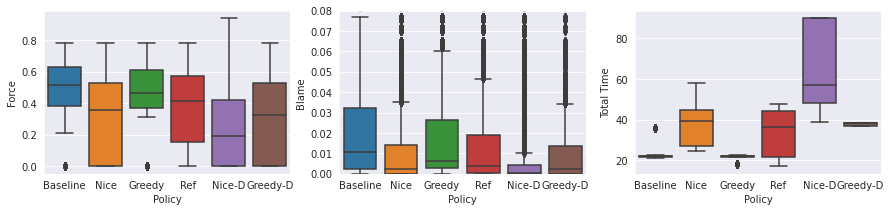

In [96]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(ncols=3, figsize=(15, 3), sharey=False)
ax[1].set_ylim([0, 0.08])
sns.boxplot(x="Policy", y="Force", data=fullDf, ax=ax[0], showfliers = True)
sns.boxplot(x="Policy", y="Blame", data=fullDf, ax=ax[1])
sns.boxplot(x="Policy", y="Total Time", data=fullDf, ax=ax[2])

In [90]:
#sns.relplot(x="Blame", y="Force", hue="Policy", kind="line", data=fullDf[fullDf["Policy"] == "NiceD"]);

In [91]:
print("Total Trials: " + str(len(fullTimes.index)))

Total Trials: 62


In [92]:
# Example of the Analysis of Variance Test
from scipy.stats import f_oneway
from scipy.stats import kruskal
from pprint import pprint
b = fullDf[fullDf["Policy"] == 'Baseline']
r = fullDf[fullDf["Policy"] == 'Reference']
n = fullDf[fullDf["Policy"] == 'Nice']
g = fullDf[fullDf["Policy"] == 'Greedy']
nd = fullDf[fullDf["Policy"] == 'NiceD']
gd = fullDf[fullDf["Policy"] == 'GreedyD']
data1 = b["Force"]
data2 = r["Force"]
data3 = n["Force"]
data4 = g["Force"]
data5 = nd["Force"]
data6 = gd["Force"]
pprint(kruskal(data1, data2, data3, data4))
stat, p = kruskal(data1, data2, data3, data4)
print('stat=%.3f, p=%.10f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

KruskalResult(statistic=nan, pvalue=nan)
stat=nan, p=nan
Probably different distributions


In [93]:
# Writing some data out to a file
force = fullDf["Force"]
blame = fullDf["Blame"]
time = fullDf["Total Time"]
trial = fullDf["Trial"]
labels = fullDf["Policy"]
result = pd.concat([labels, trial, force, blame, time], axis=1, join="inner")
print(result)
result.to_csv("rw_metrics.csv")

         Policy  Trial     Force     Blame  Total Time
0      Baseline      5  0.000000  0.000000   21.991724
1      Baseline      5  0.000000  0.000000   21.991724
2      Baseline      5  0.000000  0.000000   21.991724
3      Baseline      5  0.000000  0.000000   21.991724
4      Baseline      5  0.000000  0.000000   21.991724
...         ...    ...       ...       ...         ...
14819    Nice-D      1  0.000000  0.000684   90.000000
14820    Nice-D      1  0.000000  0.000721   90.000000
14821    Nice-D      1  0.000000  0.000721   90.000000
14822    Nice-D      1  0.318713  0.000721   90.000000
14823    Nice-D      1  0.318713  0.000721   90.000000

[208852 rows x 5 columns]


<AxesSubplot:xlabel='Force', ylabel='Blame'>

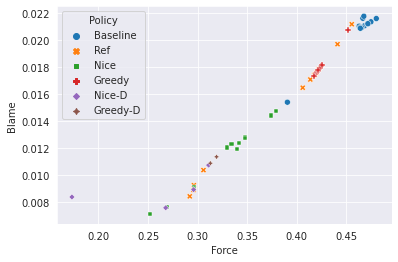

In [94]:
sns.scatterplot(data=averageDf, x="Force", y="Blame", hue="Policy", style="Policy")

<AxesSubplot:xlabel='Force', ylabel='Blame'>

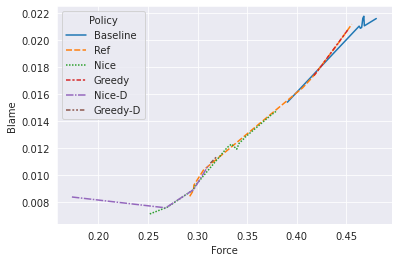

In [95]:
sns.lineplot(data=averageDf, x="Force", y="Blame", hue="Policy", style="Policy")